# MIE 1624: Final Project

#### Group 22 Members

Aaron Hao Tan, Gurtej Bhasin, Elise Emma, Jacob Bulir, Alex Kwan

## Introduction 

< -- Insert brief intro to project -- >

## Table of Content 

#### 0. Preliminaries
#### 1. Data Cleaning
    - 1.1 Claim Cleaning
    - 1.2 Related Articles Cleaning
        - 1.2.1 Extract Sentences
    - 1.3 Removing Stopwords and Stemming
        - 1.3.1 Claims
        - 1.3.2 Related Articles
    - 1.4 Date Cleaning
    - 1.5 Claimant Cleaning
    - 1.6 Finalize Cleaned Data
        - 1.6.1 Finalize Train Data
        - 1.6.2 Finalize Related Articles Data
#### 2. Exploratory Data Analysis
    - 2.1 Date Features
        - 2.1.1 Additional Date Features and Analysis
    - 2.2 Claimant Features
    - 2.3 Doc2Vec Features
        - 2.3.1 Preprocess the Data
        - 2.3.2 Prepare for Training
        - 2.3.3 Doc2Vec Training
        - 2.3.4 Find Similarities
            - 2.3.4.1 Finding Top 5 Sentences per Related Articles per Claim
            - 2.3.4.2 Finding Top 5 Sentences Amongst all Related Articles per Claim
        - 2.3.5 Feature Encoding
            - 2.3.5.1 Feature Encode the Claims
            - 2.3.5.2 Feature Encode the Top 5 Related Article Sentences for Each Claim
            - 2.3.5.3 Feature Encode the Similarity Scores
        - 2.3.6 Combine All Features (Claim Vector, Top 5 Related Sentence Vector, Similarity Scores)
    - 2.4 Sentiment Features
    - 2.5 Combining all Features

#### 3. Feature Selection
#### 4. Model Implementation and Tuning
#### 5. Results

## Preliminaries

In [1]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------
import pandas as pd
import numpy as np
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import os
import math
from IPython.display import clear_output, display
import time
import warnings
warnings.filterwarnings('ignore')
import string
import heapq
from heapq import nlargest
from operator import itemgetter
import random

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

## 1. Data Cleaning 

In this section, the train.json file as well as the related articles are cleaned. The output of this section are two data frames that hold the cleaned information. The following shows the subsections:

- 1.1 Claim Cleaning
- 1.2 Related Articles Cleaning
    - 1.2.1 Extract Sentences
- 1.3 Removing Stopwords and Stemming
    - 1.3.1 Claims
    - 1.3.2 Related Articles
- 1.4 Date Cleaning
- 1.5 Claimant Cleaning
- 1.6 Finalize Cleaned Data
    - 1.6.1 Finalize Train Data
    - 1.6.2 Finalzie Related Articles Data

### 1.1 Claim Cleaning

Read the "train.json" file and perform some basic cleaning on the claims. This includes the following key points:

    - Lowercase all claims
    - Remove "\n" new lines
    - Remove URL links
    - Remove unicode hex
    - Remove punctuations
    - Remove misc. items such as "-", "'" ... etc.
    - Remove any extra spaces

In [2]:
# read train.json file for training data
data = pd.read_json("train.json")
data.shape

(15555, 6)

In [3]:
%%time

# CLEAN CLAIM DATA

# create a new dataframe of just claims
cleaned_claim = data.claim.to_frame()

# convert all string values to lower case
cleaned_claim = cleaned_claim.apply(lambda x: x.str.lower())

# replace new line with space
cleaned_claim = cleaned_claim.replace('\n', ' ', regex=True)

# get rid of all links
cleaned_claim = cleaned_claim.claim.replace(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', regex = True).to_frame()

# get rid of unicode hex
cleaned_claim = cleaned_claim.claim.replace({r'[^\x00-\x7F]+':''}, regex=True).to_frame()

# remove punctuation
cleaned_claim = cleaned_claim.claim.str.replace('[{}]'.format(string.punctuation), '').to_frame()

# remove misc items
cleaned_claim = cleaned_claim.replace(' — ', ' ', regex=True)
cleaned_claim = cleaned_claim.replace('-', ' ', regex=True)
cleaned_claim = cleaned_claim.replace('’', '', regex=True)
cleaned_claim = cleaned_claim.replace('‘', '', regex=True)
cleaned_claim = cleaned_claim.replace('”', '', regex=True)
cleaned_claim = cleaned_claim.replace('“', '', regex=True)

# replace consecutive spaces with just one space
cleaned_claim = cleaned_claim.replace('\s+', ' ', regex=True)

CPU times: user 445 ms, sys: 2.7 ms, total: 448 ms
Wall time: 447 ms


For ease of manipulation, the related articles information are converted in to numpy arrays with the following code segment.

In [4]:
# convert related_articles list to a row of array

article_array = []
for i in range(data.shape[0]):
    array = np.asarray(data['related_articles'].loc[i])
    article_array.append(array)
    
data['article_array'] = article_array

The cleaned claims, labels and the related articles in array format are shown below.

In [5]:
# concatenate cleaned_claims with label and article_array
cleaned_claim = pd.concat([cleaned_claim, data.label, data.article_array], axis=1)

# cleaned_claim now holds the claims that are cleaned, the label, and the article array
cleaned_claim.head()

,claim,label,article_array
0,a line from george orwells novel 1984 predicts...,0,"[122094, 122580, 130685, 134765]"
1,maine legislature candidate leslie gibson insu...,2,"[106868, 127320, 128060]"
2,a 17yearold girl named alyssa carson is being ...,1,"[132130, 132132, 149722]"
3,in 1988 author roald dahl penned an open lette...,2,"[123254, 123418, 127464]"
4,when it comes to fighting terrorism another th...,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


### 1.2 Related Articles Cleaning

Similar to the procedures used to clean the claims, we clean the related articles in this section. To begin, we first create a dataframe that holds every related article. The index in this case are the article ID's.

In [6]:
%%time

# set paths
cur_path = os.path.dirname(os.path.abspath("Final_Project.ipynb"))
articles_dir = cur_path + '/train_articles/'

# create a dictionary of article ID and content
article_dict = {}
for filename in os.listdir(articles_dir):
    filenumber = filename.replace('.txt', '')
    file_open = open(articles_dir + filename, "r")
    text = file_open.read()
    article_dict[filenumber] = text
    
# use the dictionary created to create a dataframe of articles
articles  = pd.DataFrame.from_dict(article_dict, orient='index')
articles.columns = ['Article']

# a dataframe that holds all the articles
articles.head()

CPU times: user 1.44 s, sys: 459 ms, total: 1.9 s
Wall time: 1.91 s


,Article
125923,FACT CHECK: The Five Pillars of Curriculum\nFA...
57270,"The State Department Spent $52,701 on the Curt..."
144732,US show of force sends Russia a message in Bla...
28766,Mexico missing students: Protesters clash with...
85305,The U.S. Refugee Resettlement Program: A Prime...


With the related articles dataframe, the following performs the basic cleaning that was also applied to the claims.

In [7]:
%%time

# CLEAN ARTICLE DATA - ~5 minutes to run

# convert all string values to lower case
articles_cleaned = articles.apply(lambda x: x.str.lower())

# replace new line with space
articles_cleaned = articles_cleaned.replace('\n', ' ', regex=True)

# get rid of all links
articles_cleaned = articles_cleaned.Article.replace(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', regex = True).to_frame()

# get rid of unicode hex
articles_cleaned = articles_cleaned.Article.replace({r'[^\x00-\x7F]+':''}, regex=True).to_frame()

# remove misc items
articles_cleaned = articles_cleaned.replace(' — ', ' ', regex=True)
articles_cleaned = articles_cleaned.replace('-', '', regex=True)
articles_cleaned = articles_cleaned.replace('’', '', regex=True)
articles_cleaned = articles_cleaned.replace('‘', '', regex=True)
articles_cleaned = articles_cleaned.replace('”', '', regex=True)
articles_cleaned = articles_cleaned.replace('“', '', regex=True)

# replace consecutive spaces with just one space
articles_cleaned = articles_cleaned.replace('\s+', ' ', regex=True)

CPU times: user 1min 54s, sys: 653 ms, total: 1min 55s
Wall time: 1min 55s


### 1.2.1 Extract Sentences from Related Articles

In this section, we perform sentence tokenization on all the related articles to extract individual sentences from each article. Puntuations are then removed from the extracted sentences.

In [8]:
%%time

# split each article in to sentences by "sent_tokenize"
from nltk import sent_tokenize
article_sentences = []
for i in range(articles_cleaned.shape[0]):
    sentence = articles_cleaned.Article[articles_cleaned.index[i]]
    tok_sen = sent_tokenize(sentence)
    article_sentences.append(tok_sen)

CPU times: user 2min 2s, sys: 552 ms, total: 2min 2s
Wall time: 2min 3s


In [9]:
# remove punctuation from cleaned articles - had to do this after the sentences are separated
articles_cleaned = articles_cleaned.Article.str.replace('[{}]'.format(string.punctuation), '').to_frame()

In [10]:
%%time

# remove punctuation from sentences
cleaned_article_sent = []
for i in range(articles_cleaned.shape[0]):
    cleaned_sent = [''.join(c for c in s if c not in string.punctuation) for s in article_sentences[i]]
    # cleaned_article_sent is a list of lists
    # the sentences from each article is grouped in to a list, and then grouped together based on article
    cleaned_article_sent.append(cleaned_sent)

CPU times: user 50.4 s, sys: 388 ms, total: 50.8 s
Wall time: 50.8 s


The following shows the article sentences dataframe, where each cell holds a list of sentences, indexed by the related article ID.

In [11]:
# convert the cleaned_Article_sent in to a dataframe that's indexed by article ID
article_sentences = pd.Series(cleaned_article_sent).to_frame()
article_sentences.columns = ['Sentence']
article_sentences.index = articles_cleaned.index

# article sentences in a dataframe
article_sentences.head()

,Sentence
125923,[fact check the five pillars of curriculum fac...
57270,[the state department spent 52701 on the curta...
144732,[us show of force sends russia a message in bl...
28766,[mexico missing students protesters clash with...
85305,[the us refugee resettlement program a primer ...


### 1.3 Remove Stopwords and Stemming

Now that the basic cleaning and sentence extraction are completed, the next step is to remove stopwords and perform stemming on the remaining words. The purpose is to reduce the vocabulary space by keeping only the words that are meaningful.The following imports the necessary libraries to conduct these tasks.

In [12]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
# the first time running - you may need to uncomment the bottom two lines to download the necessary packages
# nltk.download('stopwords')
# nltk.download('punkt')

### 1.3.1 Claims

This section removes the stopwords and stems the claims.

In [13]:
# create a list of claims
claim_list=[]
for i in range(cleaned_claim.shape[0]):
    claim_entry = cleaned_claim.claim.loc[i]
    claim_list.append(claim_entry)

In [14]:
%%time
# tokenize every claim in the claim list generated from above
# the result is a list of tokenized claims: tokenized_claims
tokenized_claims = []
stemmed_claims = []
stemmed_sw_claims = []
for i in range(cleaned_claim.shape[0]):

    #--------------------------------------------------------------
    # stemming
    word_tokens = word_tokenize(claim_list[i])
    stemmed_tok_claims = []
    for w in word_tokens:
        stemmed_tok_claims.append(ps.stem(w))
    stemmed_string = ' '.join(stemmed_tok_claims)
    # stemmed_claims is a list of stemmed strings
    stemmed_claims.append(stemmed_string)
    
    #--------------------------------------------------------------
    # remove stop words
    stemmed_sw_string = []
    word_tokens = word_tokenize(stemmed_claims[i])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_sw_string = ' '.join(filtered_sentence)
    # stemmed_sw_claims is a list of stemmed strings without stopwords
    stemmed_sw_claims.append(stemmed_sw_string)    
        
    #--------------------------------------------------------------    
    # tokenize
    tokenized_ = word_tokenize(stemmed_sw_claims[i])
    tokenized_claims.append(tokenized_)
    
    # print progress
    progress = round((i/cleaned_claim.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 99.99%
CPU times: user 34.6 s, sys: 2.33 s, total: 36.9 s
Wall time: 34 s


### Create Claims Dataframe

The stemmed claims without stopwords are added to a claims dataframe here. In order to keep as much information as possible, each column below represent the claim at each level of the cleaning.

In [15]:
# zip together all the claim lists and create a dataframe
zipped_claims = list(zip(stemmed_claims, stemmed_sw_claims, tokenized_claims))
claims_ = pd.DataFrame(zipped_claims, columns = ['stemmed_claims', 'stemmed_stopword_claims', 'tokenized_claims'])

#display the claims dataframe
claims_.head()

,stemmed_claims,stemmed_stopword_claims,tokenized_claims
0,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow..."
1,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu..."
2,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,..."
3,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,..."
4,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,..."


### 1.3.2 Related Articles

Similar to the procedure performed on the claims, this section removes stopwords and stems the sentences extracted from the related articles.

In [16]:
%%time
# create a list of tokenized, non-stop words articles ~ takes 30 min
tokenized_articles = []
stemmed_art = []
stemmed_sw_art = []

for i in range(articles_cleaned.shape[0]):

    #--------------------------------------------------------------
    # stemming
    word_tokens = word_tokenize(articles_cleaned.Article[articles_cleaned.index[i]])
    stemmed_tok_art = []
    for w in word_tokens:
        stemmed_tok_art.append(ps.stem(w))
    stemmed_string = ' '.join(stemmed_tok_art)
    # stemmed_claims is a list of stemmed strings
    stemmed_art.append(stemmed_string)
    
    #--------------------------------------------------------------
    # remove stop words
    stemmed_sw_string = []
    word_tokens = word_tokenize(stemmed_art[i])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_sw_string = ' '.join(filtered_sentence)
    # stemmed_sw_claims is a list of stemmed strings without stopwords
    stemmed_sw_art.append(stemmed_sw_string)    
    
    #--------------------------------------------------------------    
    # tokenize
    tokenized_ = word_tokenize(stemmed_sw_art[i])
    tokenized_articles.append(tokenized_)
    
    # print progress
    progress = round((i/articles_cleaned.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 100.0%
CPU times: user 31min 20s, sys: 21 s, total: 31min 41s
Wall time: 31min 24s


#### Sentences for Related Articles

In [17]:
%%time

# stem, remove stop words from sentences ~ takes 30 min

one_article = []
final_article_sentences = []
tokenized_sentences = []
final_article_tok_sentences = []

for i in range(article_sentences.shape[0]):
    # grab a series of sentence for one article
    sentence_list = article_sentences.Sentence[article_sentences.index[i]]
    for u in range(len(sentence_list)):
        # stem, stopwords for each sentence in an article
        sent = sentence_list[u]
        word_tokens = word_tokenize(sent)
        stemmed_tok_sent = []
        for w in word_tokens:
            stemmed_tok_sent.append(ps.stem(w))
        filtered_sentence = [w for w in stemmed_tok_sent if not w in stop_words]
        # append the tokenized strings
        tokenized_sentences.append(filtered_sentence)
        # append the strings
        stemmed_sw_string = ' '.join(filtered_sentence)
        one_article.append(stemmed_sw_string)
    # append each one_article to a full list of all articles
    final_article_sentences.append(one_article)  
    final_article_tok_sentences.append(tokenized_sentences)
    one_article = []
    tokenized_sentences = []
    
    # print progress
    progress = round((i/article_sentences.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")    

progress: 100.0%
CPU times: user 29min 27s, sys: 26.5 s, total: 29min 54s
Wall time: 29min 38s


The sentences from the related articles at each level of the cleaning are shown below.

In [18]:
# article_sentences is the dataframe that holds the sentences
article_sentences['cleaned_sentence'] = final_article_sentences
article_sentences['tokenized_cleaned_sentence'] = final_article_tok_sentences
article_sentences.head()

,Sentence,cleaned_sentence,tokenized_cleaned_sentence
125923,[fact check the five pillars of curriculum fac...,[fact check five pillar curriculum fact check ...,"[[fact, check, five, pillar, curriculum, fact,..."
57270,[the state department spent 52701 on the curta...,[state depart spent 52701 curtain un ambassado...,"[[state, depart, spent, 52701, curtain, un, am..."
144732,[us show of force sends russia a message in bl...,[us show forc send russia messag black sea was...,"[[us, show, forc, send, russia, messag, black,..."
28766,[mexico missing students protesters clash with...,[mexico miss student protest clash polic media...,"[[mexico, miss, student, protest, clash, polic..."
85305,[the us refugee resettlement program a primer ...,[us refuge resettl program primer policymak pr...,"[[us, refuge, resettl, program, primer, policy..."


### Create Related Articles DataFrame

The cleaned related articles as well as the sentences are combined together into a single dataframe with the code presented below.

In [19]:
# zip together all the articles and create a dataframe
zipped_articles = list(zip(stemmed_art, stemmed_sw_art, tokenized_articles, final_article_sentences, final_article_tok_sentences))
articles_ = pd.DataFrame(zipped_articles, columns = ['stemmed_articles', 'stemmed_stopword_articles', 'tokenized_articles', 'cleaned_sentence', 'tokenized_cleaned_sentence'])

# index the articles based on article ID
articles_.index = [articles_cleaned.index]

# display the articles_
articles_.head()

,stemmed_articles,stemmed_stopword_articles,tokenized_articles,cleaned_sentence,tokenized_cleaned_sentence
125923,fact check the five pillar of curriculum fact ...,fact check five pillar curriculum fact check s...,"[fact, check, five, pillar, curriculum, fact, ...",[fact check five pillar curriculum fact check ...,"[[fact, check, five, pillar, curriculum, fact,..."
57270,the state depart spent 52701 on the curtain in...,state depart spent 52701 curtain un ambassador...,"[state, depart, spent, 52701, curtain, un, amb...",[state depart spent 52701 curtain un ambassado...,"[[state, depart, spent, 52701, curtain, un, am..."
144732,us show of forc send russia a messag in black ...,us show forc send russia messag black sea wash...,"[us, show, forc, send, russia, messag, black, ...",[us show forc send russia messag black sea was...,"[[us, show, forc, send, russia, messag, black,..."
28766,mexico miss student protest clash with polic m...,mexico miss student protest clash polic media ...,"[mexico, miss, student, protest, clash, polic,...",[mexico miss student protest clash polic media...,"[[mexico, miss, student, protest, clash, polic..."
85305,the us refuge resettl program a primer for pol...,us refuge resettl program primer policymak pre...,"[us, refuge, resettl, program, primer, policym...",[us refuge resettl program primer policymak pr...,"[[us, refuge, resettl, program, primer, policy..."


### 1.4. Date Cleaning

For ease of data manipulation, the date is converted to "datetime" format and added as a new column "new_date".

In [20]:
# Convert date column to datetime format
data['new_date'] = pd.to_datetime(data['date'], dayfirst=True)
data.head()

,claim,claimant,date,id,label,related_articles,article_array,new_date
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","[122094, 122580, 130685, 134765]",2017-07-17
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","[106868, 127320, 128060]",2018-03-17
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","[132130, 132132, 149722]",2018-07-18
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","[123254, 123418, 127464]",2019-02-04
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22


### 1.5. Claimant Cleaning 

All empty claimant cells are replaced with "Unknown" in this section.

In [36]:
# fill missing claimants with "unknown"
data['claimant'] = data['claimant'].fillna('Unknown')
data['claimant'] = data['claimant'].replace('', 'Unknown')
data.head()

,claim,claimant,date,id,label,related_articles,article_array,new_date
0,A line from George Orwell's novel 1984 predict...,Unknown,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","[122094, 122580, 130685, 134765]",2017-07-17
1,Maine legislature candidate Leslie Gibson insu...,Unknown,2018-03-17,1,2,"[106868, 127320, 128060]","[106868, 127320, 128060]",2018-03-17
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,2018-07-18,4,1,"[132130, 132132, 149722]","[132130, 132132, 149722]",2018-07-18
3,In 1988 author Roald Dahl penned an open lette...,Unknown,2019-02-04,5,2,"[123254, 123418, 127464]","[123254, 123418, 127464]",2019-02-04
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22


### 1.6. Finalize Train and Related Articles Data

With the train.json and related articles cleaned, this section forms two complete dataframes that hold the necessary information.

### 1.6.1 Finalize Cleaned Train Data

This section finalizes the cleaned train data which include the raw claim, cleaned claim, stemmed claims, stemmed claims without stopwords, tokenized claims, claimants, label, related article array and the dates.

In [45]:
# concatenate all work done above to a single frame
final_data = pd.concat([data.claim, cleaned_claim.claim, claims_.stemmed_claims, claims_.stemmed_stopword_claims, claims_.tokenized_claims, data.claimant, cleaned_claim.label, cleaned_claim.article_array, data.new_date], axis=1)

# rename columns for clarity
final_data.columns = ['raw_claim', 'cleaned_claim', 'stemmed_claims', 'stemmed_stopword_claims', 'tokenized_claim', 'claimant', 'label', 'article_array', 'new_date']

In [46]:
# this is equivalent to the "train.csv" that we were given, but cleaned
final_data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,label,article_array,new_date
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,0,"[122094, 122580, 130685, 134765]",2017-07-17
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2,"[106868, 127320, 128060]",2018-03-17
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,1,"[132130, 132132, 149722]",2018-07-18
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2,"[123254, 123418, 127464]",2019-02-04
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22


In [47]:
# save to pkl
final_data.to_pickle("./final_data.pkl")

### 1.6.2 Finalize Cleaned Related Articles Data

This part combines the necessary related article information in to a single dataframe. The columns contains the raw articles, cleaned articles, stemmed articles, stemmed articles without stopwords, tokenized articles, the cleaned sentences and lastly the tokenized cleaned sentences.

In [39]:
raw_article_list = articles.Article.tolist()
cleaned_article_list = articles_cleaned.Article.tolist()
final_articles_zipped = list(zip(raw_article_list, cleaned_article_list, stemmed_art, stemmed_sw_art, tokenized_articles, final_article_sentences, final_article_tok_sentences))
final_articles = pd.DataFrame(final_articles_zipped, columns = ['raw_articles', 'cleaned_articles', 'stemmed_articles', 'stemmed_stopwords_articles', 'tokenized_articles', 'cleaned_sentence', 'tokenized_cleaned_sentence'])
final_articles.index = [articles_cleaned.index]

In [40]:
final_articles.head()

,raw_articles,cleaned_articles,stemmed_articles,stemmed_stopwords_articles,tokenized_articles,cleaned_sentence,tokenized_cleaned_sentence
125923,FACT CHECK: The Five Pillars of Curriculum\nFA...,fact check the five pillars of curriculum fact...,fact check the five pillar of curriculum fact ...,fact check five pillar curriculum fact check s...,"[fact, check, five, pillar, curriculum, fact, ...",[fact check five pillar curriculum fact check ...,"[[fact, check, five, pillar, curriculum, fact,..."
57270,"The State Department Spent $52,701 on the Curt...",the state department spent 52701 on the curtai...,the state depart spent 52701 on the curtain in...,state depart spent 52701 curtain un ambassador...,"[state, depart, spent, 52701, curtain, un, amb...",[state depart spent 52701 curtain un ambassado...,"[[state, depart, spent, 52701, curtain, un, am..."
144732,US show of force sends Russia a message in Bla...,us show of force sends russia a message in bla...,us show of forc send russia a messag in black ...,us show forc send russia messag black sea wash...,"[us, show, forc, send, russia, messag, black, ...",[us show forc send russia messag black sea was...,"[[us, show, forc, send, russia, messag, black,..."
28766,Mexico missing students: Protesters clash with...,mexico missing students protesters clash with ...,mexico miss student protest clash with polic m...,mexico miss student protest clash polic media ...,"[mexico, miss, student, protest, clash, polic,...",[mexico miss student protest clash polic media...,"[[mexico, miss, student, protest, clash, polic..."
85305,The U.S. Refugee Resettlement Program: A Prime...,the us refugee resettlement program a primer f...,the us refuge resettl program a primer for pol...,us refuge resettl program primer policymak pre...,"[us, refuge, resettl, program, primer, policym...",[us refuge resettl program primer policymak pr...,"[[us, refuge, resettl, program, primer, policy..."


In [42]:
final_articles.to_pickle('./final_articles.pkl')

################################################################################################ 

# CHECKPOINT

**At this point, there are 2 dataframes as shown above: final_data and final_articles**

#################################################################################################

## 2. Exploratory Data Analysis

##### Introduction to EDA:
In the EDA section, we look to find trends in the data and offer insightful observations and visuals. We focus on the generating new features from information that is present in the data. Examples of this include analysis of the words used in the claim and the related articles, the date the claim was made, the person who made the claim, as well as overall sentiment analysis. EDA is crucial for allowing us to understand the patterns and trends in the data so that we can then interpret our results and check that they are reasonable and not over/underfitting the data.

In [2]:
data = pd.read_pickle('final_data.pkl')

#### Wordcloud
The wordclouds below visualize the most commonly used words for each type of claim label (true, partly true, false). Based on the wordclouds, we can see that there is overlap between common words such as "Say". However, we also see that true claims use the word "year" much more than partly true and false claims. This makes sense, as a person that can reference the year of a true claim likely has done their research. We will use these findings to guide our future analysis. 

In [3]:
# !pip install wordcloud
import wordcloud as wc

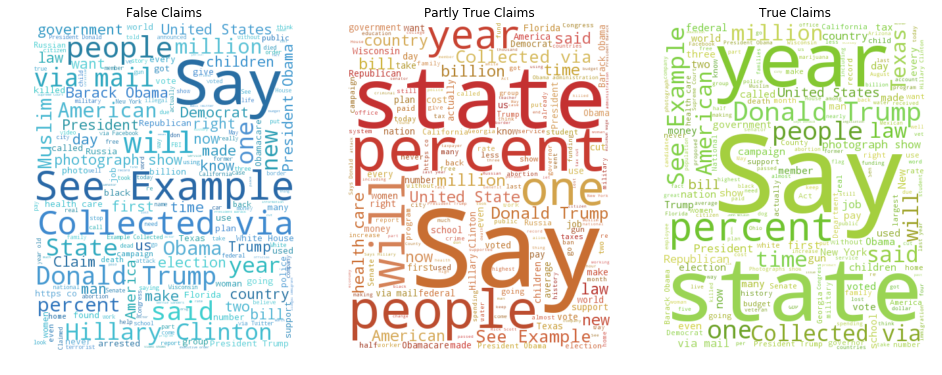

In [4]:
#Merges the words of all claims dependent on the truth label of the claim

false_text = " ".join(data[data.label==0].raw_claim)
partly_text = " ".join(data[data.label==1].raw_claim)
true_text = " ".join(data[data.label==2].raw_claim)
cv='hsl({:d}, 60%, {:d}%)'

#Defines color and sizing of visuals
def bcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(180, 210), random.randint(40, 60))

def rcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(0, 50), random.randint(40, 60))

def wcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(60, 100), random.randint(40, 60))
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=[16,8])

#Plots each wordcloud visual
wordcloud1 = wc.WordCloud(background_color='white', height=500).generate(false_text)
ax1.imshow(wordcloud1.recolor(color_func=bcolor, random_state=3),interpolation="bilinear")
ax1.axis('off');
ax1.set_title('False Claims');

wordcloud2 = wc.WordCloud(background_color='white', height=500).generate(partly_text)
ax2.imshow(wordcloud2.recolor(color_func=rcolor, random_state=3),interpolation="bilinear")
ax2.axis('off');
ax2.set_title('Partly True Claims');

wordcloud3 = wc.WordCloud(background_color='white', height=500).generate(true_text)
ax3.imshow(wordcloud3.recolor(color_func=wcolor, random_state=3),interpolation="bilinear")
ax3.axis('off');
ax3.set_title('True Claims');

### 2.1 Date Features 

This section is focused on creating features from the date information provided.

<-- include a list of features added and their description -->

In [5]:
data = pd.read_pickle('./final_data.pkl')

In [6]:
# create new feature with consecutive days since January 1st, 1986
data['start_date'] = pd.to_datetime('1986-01-01', format='%Y-%m-%d')
data['cont_days'] = (data['new_date'] - data['start_date']).dt.days
data = data.drop(['start_date'], axis=1)

# Convert Year and Month features in to int (instead of str before), can be kept as int since it is ordinal

#Year
data['Year'] = data['new_date'].apply(lambda x: "%d" % (x.year))
data['Year'] = data['Year'].astype(int)

# Month
data['Month'] = data['new_date'].apply(lambda x: "%d" % (x.month))
data['Month'] = data['Month'].astype(int)

#### Some Date Graphs

Text(0, 0.5, 'Count')

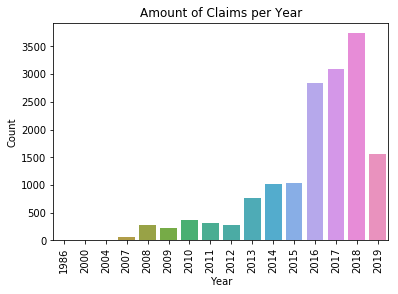

In [7]:
# claims per year
sns.barplot(x=data['new_date'].dt.year.value_counts().index, y=data['new_date'].dt.year.value_counts())
plt.xticks(rotation=90)
plt.title('Amount of Claims per Year')
plt.xlabel('Year')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

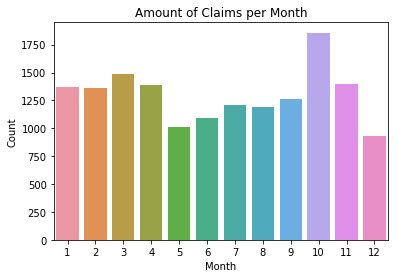

In [8]:
# Claims per month
sns.barplot(x=data['new_date'].dt.month.value_counts().index, y=data['new_date'].dt.month.value_counts())
plt.title('Amount of Claims per Month')
plt.xlabel('Month')
plt.ylabel('Count')

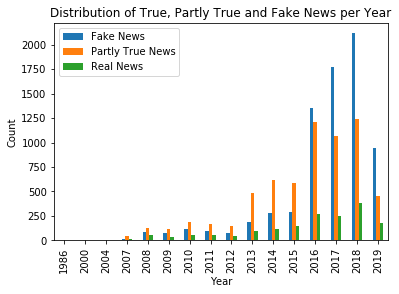

In [9]:
# Plot labels against each year
data['Year'] = data['new_date'].apply(lambda x: "%d" % (x.year))
year_label = data.groupby(['Year', 'label']).size().unstack(fill_value=0)
year_label.plot.bar()
plt.title('Distribution of True, Partly True and Fake News per Year')
plt.ylabel('Count')
plt.legend(["Fake News", "Partly True News", "Real News"])
# 0 = false, 1 = partly true, 2 = true

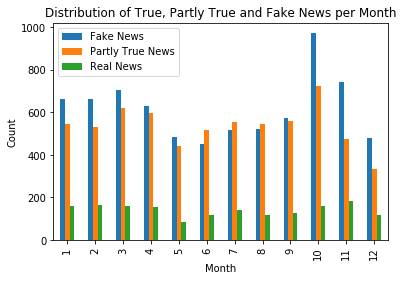

In [10]:
# Plot labels against each month
data['Month'] = data['new_date'].apply(lambda x: "%d" % (x.month))
month_label = data.groupby(['Month', 'label']).size().unstack(fill_value=0)
# For some reason, have to reorder the month index by adding a new column
month_order = [1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]
month_label['month'] = month_order
month_label = month_label.sort_values(by=['month'])
# Dropping the added column as it is not needed after reordering
month_label = month_label.drop(['month'], axis=1)
month_label.plot.bar()

plt.title('Distribution of True, Partly True and Fake News per Month')
plt.ylabel('Count')
plt.legend(["Fake News", "Partly True News", "Real News"])

In [11]:
data.to_pickle('./final_data_dates.pkl')

### 2.1.1 Additional Date Features and Analysis

##### New Features Generated (Process discussed in the section below):
1. Day of week
2. IsWeekend?
3. Season of year
4. Semester of year

In [12]:
data = pd.read_pickle('./final_data_dates.pkl')

We visualize the amount of claims for a given week (range 1-52) for all the years for which we have data, as shown in the cell below. We see that each year varies drastically in the amount of claims. For example, year 2012 only has an average of 12 claims per week (in this dataset), whereas year 2016 has an average of around 50 and a peak of over 400. 

With this in mind, we developed new features with dates that take into account the seasonal nature of claims on a per year basis. For example, we see that there are a larger amount of claims being made toward the end of the year. We made more features with the idea that we will then eliminate them based on the correlation between them and the label.

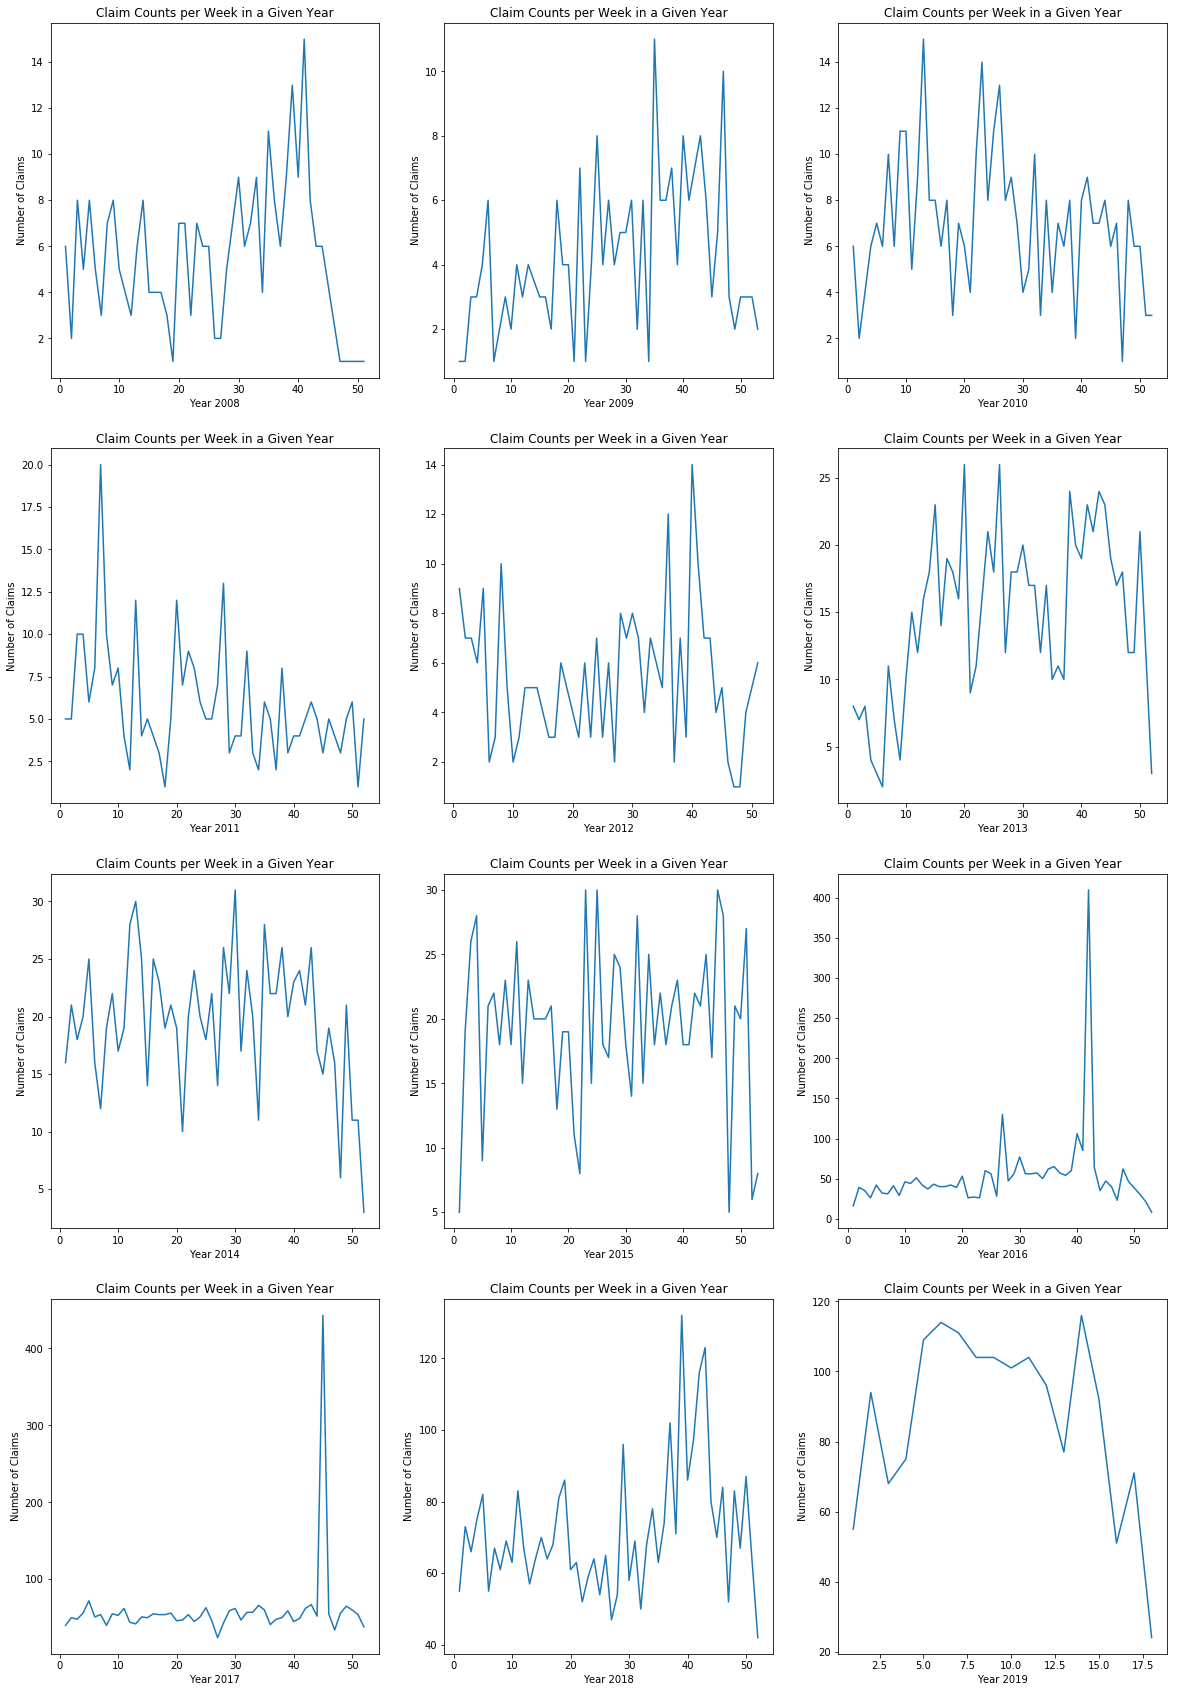

In [13]:
#Plots the amount of claims per week for a given year
fig = plt.figure(figsize=(20,30))
yr_list = list(range(2008, 2020))
for i in range(1, 13):
    plt.subplot(4,3, i)
    data2 = data["new_date"].dt.year.isin([yr_list[i-1]])
    plt.plot(data[data2]["new_date"].dt.week.value_counts().sort_index())
    plt.xlabel("Year " + str(i + 2007))
    plt.ylabel("Number of Claims")
    plt.title("Claim Counts per Week in a Given Year")

#### Day of Week

We defined days since the first claim was made. We then adjusted a mod 7 function to correspond to Monday = 1, Tuesday = 2, ... Sunday = 7. This approach is resilient to leap years and other factors, since monday will always follow sunday and similar for the rest of the days.

In [14]:
#Use days since first claim and mod function to determine the day of week
data2 = pd.DataFrame()
data2["day_of_week"] = data["cont_days"].apply(lambda x: ((x+2) % 7) + 1)
#Map to corresponding strings
day_dic = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
data2.replace({"day_of_week": day_dic}, inplace=True)

#### IsWeekend?

In [15]:
#If Friday-Sunday, then assign Weekend label
data2["is_weekend"] = data2["day_of_week"].apply(lambda x: 'Weekend' if x in ['Friday','Saturday','Sunday'] else 'notWeekend')

#### Transformation of Year into Quarters

The following two features are meant to potentially identify seasonal trends independent of the year the claim was made. For example, this representation could identify if more false claims were made between november-december in each year. This is partially an extension of the month feature.

In [16]:
#Divide year into four different seasons and label accordingly
def season_buckets(month):
    if month <= 3:
        return 'Jan-March'
    elif month <= 6:
        return 'April-June'
    elif month <= 9:
        return 'July-September'
    elif month <= 12:
        return 'October-December'
    else:
        return 0

In [17]:
data2["season"] = data["Month"].astype(int).apply(season_buckets)

#### Transformation of Year into Semesters

In [18]:
#Define which half of the year a date belongs to based off of month value
def semester_buckets(month):
    if month <= 6:
        return 'Jan-June'
    elif month <= 12:
        return 'July-December'
    else:
        return 0
data2["semester"] = data["Month"].astype(int).apply(semester_buckets)
data2.head(5)

,day_of_week,is_weekend,season,semester
0,Monday,notWeekend,July-September,July-December
1,Saturday,Weekend,Jan-March,Jan-June
2,Wednesday,notWeekend,July-September,July-December
3,Monday,notWeekend,Jan-March,Jan-June
4,Tuesday,notWeekend,Jan-March,Jan-June


In [19]:
day_dum = pd.get_dummies(data2['day_of_week'], prefix = 'day')
weekend_dum = pd.get_dummies(data2['is_weekend'])
season_dum = pd.get_dummies(data2['season'], prefix = 'season')
semester_dum = pd.get_dummies(data2['semester'], prefix = 'semester')
year_dum = pd.get_dummies(data['Year'], prefix = 'year')
month_dum = pd.get_dummies(data['Month'], prefix = 'month')

data3 = pd.concat([data['cont_days'], day_dum, weekend_dum, season_dum, semester_dum, year_dum, month_dum], axis=1)
data3.head(5)

,cont_days,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,Weekend,notWeekend,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,11520,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,11763,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,11886,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,12087,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,11038,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [20]:
data3.to_pickle('date_features.pkl')

### 2.2 Claimant Features 

##### New Features Generated (Process discussed in the section below):
1. Gender (implicitly checks if the name represents a person)
2. isPolitician?


In [21]:
data = pd.read_pickle('./final_data_dates.pkl')

In this section, we generate new features using the claimant field of the claim data. For example, for the top claimant of 'Donald Trump', we generate new features by classifying him as a politician and a person.

When using the model on test classifications, we need to check back and be aware that the model may be underfitting by assigning the majority class to a person. For example, 'bloggers' has a majority of False claims, but we should make sure that the model is not acquiring a solid accuracy by just assigning the majority class for these claimants.

In [22]:
# !pip install gender_guesser
import gender_guesser.detector as gender

In [23]:
#Takes the most frequently appearing claimants and isolates their label from the data
a = data['claimant'].value_counts()[1:].head(10)
top_10_clm = a.index.tolist()
data_list =[]
for top in top_10_clm:
    top_rows = data[data['claimant'] == top]
    label_count = top_rows.groupby('label').count()['raw_claim'].tolist()
    data_list.append(label_count)

Text(0, 0.5, 'Claim Count')

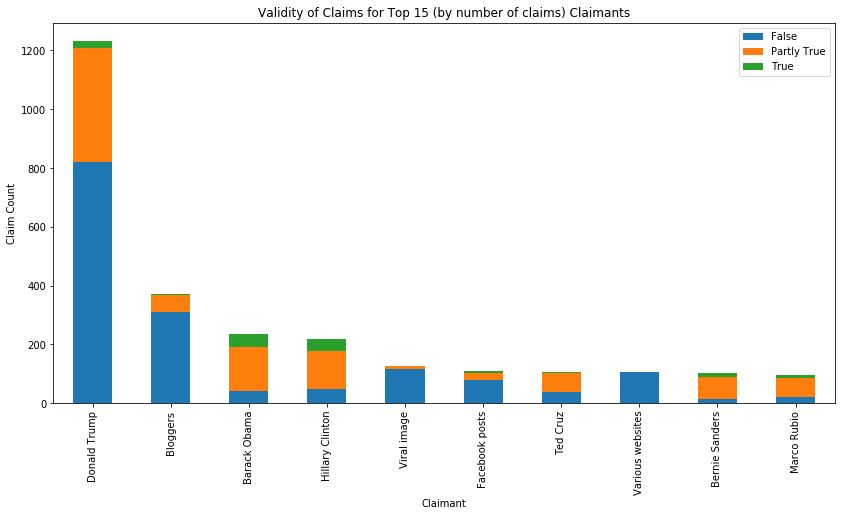

In [24]:
#Prepares dataframe with indices and values for plotting
claimant_df = pd.DataFrame(index=top_10_clm,  data=data_list, columns=['False', 'Partly True', 'True'])
#After checking df, some of the sources have only false entries, so we can fill missing indices (True/Partly) with 0's
claimant_df.fillna(0, inplace=True)
ax = claimant_df.plot(kind="bar", stacked=True, figsize=(14,7), title= 'Validity of Claims for Top 15 (by number of claims) Claimants')
plt.xlabel('Claimant')
plt.ylabel('Claim Count')

#### Claimants as Features
We will dummy encode all of the different claimants at section 3. The graph is above is a visualization of the observed trends for top 10 claimants

#### Gender (Classifier also implicitly checks for isPerson)

In [25]:
#Takes the first word in claimant string, and checks if it is a name, and if it is then assigns a gender 
#If claimant is missing or classified as other/unknown, we distinguish between these cases
def gender_recog(claimant):
    g_d = gender.Detector()
    if claimant == "Unknown":
        return 0
    elif claimant == "Other":
        return 1
    elif claimant == "nan":
        return -1
    else:
        gen_class = g_d.get_gender(claimant.split()[0])
    if gen_class in ["unknown"]:
        return 2
    if gen_class in ["mostly_female", "female"]:
        return 3
    if gen_class in ["mostly_male", "male"]:
        return 4

In [26]:
%%time
#Gender classifier runs through all the claimant data
gender_list = []
i = 0
for claimant in data['claimant']:
    gender_num = gender_recog(claimant)
    gender_list.append(gender_num) 
    
    # print progress
    i += 1
    progress = round((i/data['claimant'].shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 100.0%
CPU times: user 1h 35min 34s, sys: 1min 3s, total: 1h 36min 37s
Wall time: 1h 35min 39s


In [27]:
#Remap the dataframe values for gender to interpretable results
data2 = pd.DataFrame()
data2['gender'] = gender_list
gend = {-1: 'NaN', 0: 'Unknown', 1: 'Other', 2: 'Not Person-Result', 3: 'Female-Result', 4: 'Male-Result'}
data2.replace({'gender': gend}, inplace=True)
#encoding of gender classifier
gender_dum = pd.get_dummies(data2['gender'], prefix = 'gender')

#### isPolitician?

We compiled a large public list of North American politicians, which we then cross reference with our claimants. If the claimant is in the list, then we consider the claimant as a politician.

In [28]:
pol_list = pd.read_csv('us_politicians.csv')
#Amount of claimants recognized as politicians under True value
data.claimant.isin(pol_list['name']).value_counts()

False    12557
True      2998
Name: claimant, dtype: int64

In [29]:
#Add as a feature to dataframe
is_pol = data.claimant.isin(pol_list['name']).astype(int)
data2['isPolitician'] = is_pol
#Retrieves the labels (fake, true, partly true) for claims made by politicians 
comb_data = pd.concat([data['label'], data2['isPolitician']], axis=1, sort=False)
data_list =[]
for num in range(0,2):
    is_pol = comb_data[comb_data['isPolitician'] == num]
    label_count = is_pol.groupby('label').count()['isPolitician'].tolist()
    data_list.append(label_count)

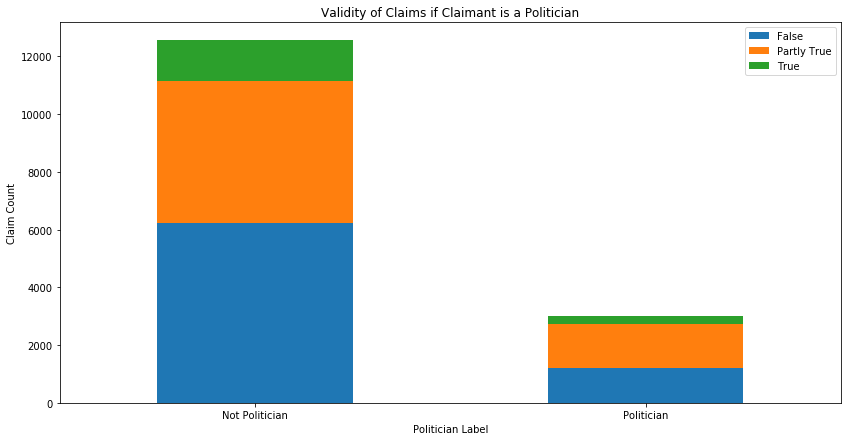

In [30]:
claimant_df = pd.DataFrame(index=['Not Politician', 'Politician'],  data=data_list, columns=['False', 'Partly True', 'True'])
#After checking df, some of the sources have only false entries, so we can fill missing indices (True/Partly) with 0's
claimant_df.fillna(0, inplace=True)
ax = claimant_df.plot(kind="bar", stacked=True, figsize=(14,7), title='Validity of Claims if Claimant is a Politician')
plt.xlabel('Politician Label')
plt.ylabel('Claim Count')
plt.xticks(rotation='horizontal')
plt.show()

In [31]:
#Below we can see the breakdown of the truthfulness of the claims as a fraction for politicians/non-politicians
claimant_df['Total'] = claimant_df.sum(axis=1)
claimant_df['False_fraction'] = claimant_df['False'] / claimant_df['Total']
claimant_df['Partly_true_fraction'] = claimant_df['Partly True'] / claimant_df['Total']
claimant_df['True_fraction'] = claimant_df['True'] / claimant_df['Total']
claimant_df

,False,Partly True,True,Total,False_fraction,Partly_true_fraction,True_fraction
Not Politician,6213,4927,1417,12557,0.494784,0.392371,0.112845
Politician,1195,1524,279,2998,0.398599,0.508339,0.093062


In [32]:
#Concatenates the features generated by is_politician and gender classifier
data3 = pd.concat([data2['isPolitician'], gender_dum], axis=1)
data3.head(5)

,isPolitician,gender_Female-Result,gender_Male-Result,gender_Not Person-Result,gender_Unknown
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,1,1,0,0,0


In [33]:
data3.to_pickle('claimant_features.pkl')

### 2.3 Doc2Vec Features

In order for machine learning models to learn, data must be in numerical form. As a result, it is necessary to represent words and sentences as numerical features. To do this, there are several Natural Language Processing techniques such as bag of words or term frequency. However, these methods of encoding words have a flaw in the sense that they create an unique number for every word/sentence which disables the computer from learning association/similarities between similar words/phrases. To solve this problem, *doc2vec* was developed in 2014 by Mikilov and Le as a way to embedd and convert documents into an n-dimensional vector. To achieve this, a doc2vec model must first be trained on the text corpus (With an associated document label). For our application, all the related article sentences as well as the claims are used as training material for our own doc2vec model. With the trained model, we will then be able to obtain the n-dimensional vector for each claim and sentence in our dataset. It is important to note that it is also possible to infer new vectors for previously unseen text data with this model.

In [35]:
# # read the data
data = pd.read_pickle("./final_data_dates.pkl")
articles = pd.read_pickle('./final_articles.pkl')
# data = final_data
# articles = final_articles

### 2.3.1 Preprocess the Data 

This section preprocesses the claims and related articles data to prepare for Doc2Vec training. To start, a label is generated for every sentence of every related article. For example "125923-5" represents the 5th sentence of article ID 125923.

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy import spatial
import random

In [37]:
%%time

# 2 minutes to run
# create a label for every sentence based on article ID (eg. 12345-1, 12345-2, 12345-3 ... etc.)

full_sentences_ID = []
for i in range(articles.shape[0]):
    sentence_ID_list = []
    sentence_number = 0
    sentences = articles.tokenized_cleaned_sentence.loc[articles.index[i]]
    for u in range(len(sentences)):
        sentence_ID = str(articles.index[i][0]) +  '-' + str(sentence_number)
        sentence_number += 1
        sentence_ID_list.append(sentence_ID)
    full_sentences_ID.append(sentence_ID_list)
    
    # print progress
    progress = round((i/articles.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 100.0%
CPU times: user 1min 45s, sys: 9.4 s, total: 1min 54s
Wall time: 1min 42s


In [38]:
# combine the tokenized sentences with their ID
articles_tok_sent = articles.tokenized_cleaned_sentence.to_frame()
articles_tok_sent['sentence_ID'] = full_sentences_ID
articles_tok_sent.head()

,tokenized_cleaned_sentence,sentence_ID
125923,"[[fact, check, five, pillar, curriculum, fact,...","[125923-0, 125923-1, 125923-2, 125923-3, 12592..."
57270,"[[state, depart, spent, 52701, curtain, un, am...","[57270-0, 57270-1, 57270-2, 57270-3, 57270-4, ..."
144732,"[[us, show, forc, send, russia, messag, black,...","[144732-0, 144732-1, 144732-2, 144732-3, 14473..."
28766,"[[mexico, miss, student, protest, clash, polic...","[28766-0, 28766-1, 28766-2, 28766-3, 28766-4, ..."
85305,"[[us, refuge, resettl, program, primer, policy...","[85305-0, 85305-1, 85305-2, 85305-3, 85305-4, ..."


In [ ]:
# %%time

# # combine the sentence list and index list ~ takes 1.5 hours to run

# article_sent_list = []
# article_sent_ID = []

# for i in range(articles_tok_sent.shape[0]):
#     one_article_sent = articles_tok_sent.tokenized_cleaned_sentence.loc[articles.index[i]]
#     article_sent_list = article_sent_list + one_article_sent
#     one_article_ID = articles_tok_sent.sentence_ID.loc[articles.index[i]]
#     article_sent_ID = article_sent_ID + one_article_ID
    
#     # print progress
#     progress = round((i/articles_tok_sent.shape[0])*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

In [ ]:
# # create a data frame of the independent sentences and ID

# # create copies
# l1 = article_sent_list
# l2 = article_sent_ID
# # make dataframe
# article_information = pd.Series(l2).to_frame()
# article_information.columns = ['sentence_ID']
# article_information['sentences'] = l1
# # display it
# article_information.head()

In [ ]:
# # save it to pickle
# article_information.to_pickle("./article_sentences_ind.pkl")

Every sentence of every related article along with the respective ID's are added to the following dataframe for Doc2Vec training.

In [40]:
sentences_pkl = pd.read_pickle("./article_sentences_ind.pkl")
# sentences_pkl = article_information
sentences_pkl.head()

,sentence_ID,sentences
0,125385-0,"[dr, ben, carson, welfar, benefactor]"
1,125385-1,"[initi, unlik, clearli, formid, contend, 2016,..."
2,125385-2,"[unlik, chri, christi, rand, paul, mike, hucka..."
3,125385-3,"[carson, becam, somewhat, overnight, sensat, f..."
4,125385-4,"[earliest, version, meme, date, least, decemb,..."


In [41]:
# extract the lists from the dataframes
sentence_ID_list = sentences_pkl.sentence_ID.tolist()
sentence_list = sentences_pkl.sentences.tolist()

### 2.3.2 Prepare for Training

The related article sentences along with the claims are added together with their ID's in this section for Doc2Vec training.

In [42]:
%%time
    
# create a list of claim index ranging from 0 - 15554
claim_range = range(0, 15555)
claim_index = []
for i in claim_range:
    claim_index.append(i)

# create a list of lists of data.tokenized_claim
tokenized_claims = []
for i in range(data.shape[0]):
    tokenized_claims.append(data.tokenized_claim[i])
    
# convert claim index to string to match the sentences ID
claim_str_index = list(map(str, claim_index))

# form full list for training
full_text_list = sentence_list + tokenized_claims
full_ID_list = sentence_ID_list + claim_str_index

CPU times: user 394 ms, sys: 16.1 ms, total: 410 ms
Wall time: 410 ms


In [43]:
# combine above 2 lists in to a dictionary for debugging
complete_data = dict(zip(full_ID_list, full_text_list))

### 2.3.3 Doc2Vec Training 

The code to enable Doc2Vec training is implemented below. Some key parameters are a vector size of 150 and 30 epochs.

In [ ]:
# %%time

# #create tagged data to train doc2vec w claim
# tagged_data = [TaggedDocument(words=full_text_list[i], tags=[full_ID_list[i]]) for i in range(len(full_text_list))]

In [ ]:
# %%time

# # 6 hours to run

# import multiprocessing
# n_cpu = multiprocessing.cpu_count()

# # setup training
# vec_size = 150
# model = Doc2Vec(dm = 1, vector_size = vec_size, min_count = 2, workers = n_cpu, epochs=30)

# # build vocab
# model.build_vocab(tagged_data)

# # train
# model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# # save model
# model.save("30epoch_150vec.model")
# print("Model Saved")

### 2.3.4 Find Cosine Similarities 

In this section, similarities between claims and its related article sentences are calculated using *Cosine similarity*. This is a measure of how similar two vectors are by comparing the cosine angle between them. In our specific application, we are using the 150 dimensional vector that is generated for each claim and related article sentence. As an example, the Cosine distance between *u* and *v* is defined below. This is implemented with a SciPy function: *scipy.spatial.distance.cosine*

$$
1-\frac{u \cdot v}{\|u\|_{2}\|v\|_{2}}
$$

In [45]:
%%time

# load the model
model = Doc2Vec.load("30epoch_150vec.model")

CPU times: user 12.6 s, sys: 1.63 s, total: 14.2 s
Wall time: 14.2 s


### 2.3.4.1 Finding Top 5 Sentences per Related Articles per Claim 

Find the top 5 sentences for each related article per claim. For example, Claim 0 has 5 related articles. Within each related article, top 5 most similar sentences are extracted. As a result, 25 total sentences are extracted from the 5 related articles. The similarity score of the sentences per related article is averaged, and then the 5 averages are averaged again to create an average similarity score between the claim and the 5 top 5 sentences of each 5 related articles.

In [46]:
%%time

# ~ 6 minutes to run
# find the top 5 sentence ID from each related article with the highest similarity score with the claim

final_best_sentences_ID = []
for i in range(data.shape[0]): # iterating over every claim
    one_claim_array = data.article_array.loc[i]
    best_sentences_one_claim = []
    for u in range(len(one_claim_array)): # iterating every article of one claim
        one_article_ID = one_claim_array[u]
        sent_list = articles.tokenized_cleaned_sentence.loc[str(one_article_ID)].iloc[0]
        one_article_sim_list=[]
        for y in range(len(sent_list)): #iterating over every sentence of one article
            v1 = model.docvecs[str(i)]
            sentence_number = str(str(one_article_ID) + '-' + str(y))
            v2 = model.docvecs[sentence_number]
            similarity = 1 - spatial.distance.cosine(v1, v2)
            one_article_sim_list.append(similarity)
#             print("ID: " + str(i) + " " + str(result))
        a = numpy.array(one_article_sim_list)
        best_sentences_one_article = heapq.nlargest(5, range(len(a)), a.take)   
        best_sentences_one_claim.append(best_sentences_one_article)
    final_best_sentences_ID.append(best_sentences_one_claim)
    # print progress
    progress = round((i/data.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# add it to the data frame
data['best_sentences_ID'] = final_best_sentences_ID

progress: 99.99%
CPU times: user 6min 7s, sys: 8.65 s, total: 6min 16s
Wall time: 6min 10s


In [47]:
%%time

# ~ 2 minuts to run
# calculate the top 5 similarity scores

end = data.shape[0]
# end = 2
avg_sim_for_one_claim_list = []
avg_sim_one_claim = []
full_sentence_ID = []
for i in range(end): # per row
    one_claim_articles_ID = data.article_array.loc[i]
    one_claim_sentences_ID = data.best_sentences_ID.loc[i]
    avg_sim_for_one_article = []
    article_sentence_ID = []
#     print("claim: " + str(i))
    for u in range(len(one_claim_articles_ID)): # article_array index
        sim_for_one_article = []
        sentence_ID_list = []
        for y in range(len(one_claim_sentences_ID[u])): # sentence ID index      
            sentence_ID = str(one_claim_articles_ID[u]) + '-' + str(data.best_sentences_ID.loc[i][u][y])
            sentence_ID_list.append(sentence_ID)
            # calculate sim score
            v1 = model.docvecs[str(i)]
            v2 = model.docvecs[sentence_ID]
            similarity = 1 - spatial.distance.cosine(v1, v2)
            # similarity between claim and each sentence is calculated
            sim_for_one_article.append(similarity)
#             print(str(sentence_ID) + ": " + str(similarity))
        # the similarity between claim and each sentence per article is averaged
        avg_sim = sum(sim_for_one_article)/len(sim_for_one_article)
        avg_sim_for_one_article.append(avg_sim)
#         print("")
        article_sentence_ID.append(sentence_ID_list)
    
    # create a list of sentence ID's
    full_sentence_ID.append(article_sentence_ID)
    
    #calculate average scores for each claim
    avg_sim_ = sum(avg_sim_for_one_article)/len(avg_sim_for_one_article)
    avg_sim_one_claim.append(avg_sim_)
    
    # a list of lists, big list per claim, and small list per article
    avg_sim_for_one_claim_list.append(avg_sim_for_one_article)
    
    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 99.99%
CPU times: user 1min 10s, sys: 4.1 s, total: 1min 14s
Wall time: 1min 12s


In [48]:
# add to data frame
data['full_sentence_ID'] = full_sentence_ID
data['avg_sentence_sim'] = avg_sim_for_one_claim_list
data['avg_sim_score'] = avg_sim_one_claim

In [49]:
data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,label,article_array,new_date,cont_days,Year,Month,best_sentences_ID,full_sentence_ID,avg_sentence_sim,avg_sim_score
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,0,"[122094, 122580, 130685, 134765]",2017-07-17,11520,2017,7,"[[0, 21, 15, 20, 10], [11, 24, 12, 13, 26], [3...","[[122094-0, 122094-21, 122094-15, 122094-20, 1...","[0.26672267615795137, 0.24059542417526245, 0.1...",0.185311
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2,"[106868, 127320, 128060]",2018-03-17,11763,2018,3,"[[11, 7, 13, 3, 4], [22, 24, 0, 1, 19], [0, 8,...","[[106868-11, 106868-7, 106868-13, 106868-3, 10...","[0.382437926530838, 0.374161022901535, 0.28886...",0.348489
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,1,"[132130, 132132, 149722]",2018-07-18,11886,2018,7,"[[22, 30, 8, 32, 29], [3, 6, 59, 60, 83], [6, ...","[[132130-22, 132130-30, 132130-8, 132130-32, 1...","[0.45887559056282046, 0.6421806216239929, 0.29...",0.464089
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2,"[123254, 123418, 127464]",2019-02-04,12087,2019,2,"[[51, 41, 70, 103, 30], [107, 102, 61, 191, 98...","[[123254-51, 123254-41, 123254-70, 123254-103,...","[0.7696409344673156, 0.7453237056732178, 0.755...",0.756903
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22,11038,2016,3,"[[168, 170, 45, 191, 32], [10, 12, 4, 16, 25],...","[[41099-168, 41099-170, 41099-45, 41099-191, 4...","[0.4999494135379791, 0.408842134475708, 0.3396...",0.411560


### 2.3.4.2 Finding Top 5 Sentences Amongst all Related Articles per Claim

In this section, instead of finding top 5 sentences from each related article, the top 5 sentences from ALL related articles of a claim is extracted. The average similarity score between the claim and the top 5 sentences are calculated and added as a feature.

In [50]:
%%time

# 1 min to run
# finding top 5 sentences amongst all relateld articles per claim

end = data.shape[0]
# end = 10

sim_score_dict = {}

final_top_sentences = []

for i in range(end):
    top_sentence_list = data.full_sentence_ID.loc[i]
    sim_score_tuple = []
    for u in range(len(top_sentence_list)):
        for y in range(len(top_sentence_list[u])):
            sentence_ID = top_sentence_list[u][y]
            # calculate sim score
            v1 = model.docvecs[str(i)]
            v2 = model.docvecs[sentence_ID]
            similarity = 1 - spatial.distance.cosine(v1, v2)
#             sim_for_one_claim.append(similarity)
            sim_score_tuple.append(tuple((sentence_ID, similarity)))
#             print(str(sentence_ID) + ": " + str(similarity))
    a = nlargest(5, sim_score_tuple, key=itemgetter(1))
    top_sentences = [q[0] for q in a]
    # list of lists: final top 5 sentences amongst all related articles per claim
    final_top_sentences.append(top_sentences)
    
    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# save it to the dataframe
data['top_5_sentences'] = final_top_sentences

progress: 99.99%
CPU times: user 49.9 s, sys: 3.22 s, total: 53.1 s
Wall time: 50.5 s


In [51]:
%%time

# average similarity scores of top 5 sentences amongst all relateld articles per claim

end = data.shape[0]
# end = 10

total_avg_sim = []

for i in range(end):
    top_sentence_list = data.top_5_sentences.loc[i]
    top_sim_scores = []
    for u in range(len(top_sentence_list)):
        sentence_ID = top_sentence_list[u]
        # calculate sim score
        v1 = model.docvecs[str(i)]
        v2 = model.docvecs[sentence_ID]
        similarity = 1 - spatial.distance.cosine(v1, v2)       
        top_sim_scores.append(similarity)
        
    avg_sim = sum(top_sim_scores)/len(top_sim_scores)
    total_avg_sim.append(avg_sim)
    
    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# save it to the dataframe
data['top5_avg_sim'] = total_avg_sim

progress: 97.53%


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,label,article_array,new_date,cont_days,Year,Month,best_sentences_ID,full_sentence_ID,avg_sentence_sim,avg_sim_score,top_5_sentences,top5_avg_sim
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,0,"[122094, 122580, 130685, 134765]",2017-07-17,11520,2017,7,"[[0, 21, 15, 20, 10], [11, 24, 12, 13, 26], [3...","[[122094-0, 122094-21, 122094-15, 122094-20, 1...","[0.26672267615795137, 0.24059542417526245, 0.1...",0.185311,"[122094-0, 122580-11, 122094-21, 122094-15, 12...",0.291527
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2,"[106868, 127320, 128060]",2018-03-17,11763,2018,3,"[[11, 7, 13, 3, 4], [22, 24, 0, 1, 19], [0, 8,...","[[106868-11, 106868-7, 106868-13, 106868-3, 10...","[0.382437926530838, 0.374161022901535, 0.28886...",0.348489,"[106868-11, 106868-7, 127320-22, 127320-24, 12...",0.400307
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,1,"[132130, 132132, 149722]",2018-07-18,11886,2018,7,"[[22, 30, 8, 32, 29], [3, 6, 59, 60, 83], [6, ...","[[132130-22, 132130-30, 132130-8, 132130-32, 1...","[0.45887559056282046, 0.6421806216239929, 0.29...",0.464089,"[132132-3, 132132-6, 132132-59, 132132-60, 132...",0.642181
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2,"[123254, 123418, 127464]",2019-02-04,12087,2019,2,"[[51, 41, 70, 103, 30], [107, 102, 61, 191, 98...","[[123254-51, 123254-41, 123254-70, 123254-103,...","[0.7696409344673156, 0.7453237056732178, 0.755...",0.756903,"[127464-222, 123254-51, 123254-41, 123254-70, ...",0.775002
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22,11038,2016,3,"[[168, 170, 45, 191, 32], [10, 12, 4, 16, 25],...","[[41099-168, 41099-170, 41099-45, 41099-191, 4...","[0.4999494135379791, 0.408842134475708, 0.3396...",0.411560,"[41099-168, 95344-259, 95344-247, 95344-74, 95...",0.547029


In [53]:
# # save to data frame
data.to_pickle("./data_sentence_simscore.pkl")

### 2.3.5 Feature Encoding

In this section, the claims, related article sentences and similarity scores are encoded in to numerical values for our fake news classfication model.

In [54]:
# # load the files

full_data = pd.read_pickle("./data_sentence_simscore.pkl")
# full_data = data

### 2.3.5.1 Feature Encode the Claims

This section applies the trained Doc2Vec model to generate a vector of size 150 for each claim.

In [55]:
# create a list of lists containing the claim's vector
claim_vectors = []
for i in range(0, 15555):
    claim_vectors.append(model.docvecs[str(i)])

# create a list of column names
column_name_list = []
for i in range(0,150):
    column_name = "claim_vec_" + str(i)
    column_name_list.append(column_name)

# turn the claim vectors in to a dataframe and rename the columns accordingly
claim_features = pd.DataFrame.from_records(claim_vectors)
claim_features.columns = column_name_list

In [56]:
claim_features.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,claim_vec_140,claim_vec_141,claim_vec_142,claim_vec_143,claim_vec_144,claim_vec_145,claim_vec_146,claim_vec_147,claim_vec_148,claim_vec_149
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,-0.283741,-0.166108,-0.125862,0.316487,-0.086704,-0.015346,0.263394,0.236137,0.191386,-0.144861
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,-0.216366,0.181766,0.237602,0.279045,-0.126447,-0.209171,-0.191039,0.158190,-0.066281,-0.247980
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,-0.155529,-0.015081,0.274674,0.272769,-0.237696,0.130785,-0.032134,0.104650,0.257081,0.016224
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,-0.336580,-0.263726,-0.080669,0.152311,-0.093220,0.300876,-0.068453,0.307259,0.150425,-0.206309
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,-0.029561,-0.171704,0.290350,0.440742,-0.249992,0.430053,-0.086707,0.252833,-0.295727,0.226280


### 2.3.5.2 Feature Encode the Top 5 Related Article Sentences for Each Claim

In thi section, the top 5 sentences from all related articles per claim are encoded by using the Doc2Vec model to generate a vector for each sentence. (5 sentences, 150 vectors each, 750 columns of features in total).

In [57]:
%%time

end = full_data.shape[0]
# end = 1
full_sentence_vector_list = []
for i in range(end):
    top_5_sentences = full_data.top_5_sentences.loc[i]
    sentence_vector_list = []
    for u in range(len(top_5_sentences)):
        sentence_ID = full_data.top_5_sentences.loc[i][u]
        sentence_vector = model.docvecs[sentence_ID]
        sentence_vector_list.extend(sentence_vector)
    full_sentence_vector_list.append(sentence_vector_list)

    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# create column names
complete_column_name=[]
for i in range(1, 6):
    column_name_list = []
    for u in range(0,150):
        column_name = "sent_" + str(i) + "vec_" + str(u)
        column_name_list.append(column_name)
    complete_column_name.extend(column_name_list)

# convert full sentence features in to dataframe and name the columns accordingly
sentence_features = pd.DataFrame.from_records(full_sentence_vector_list)
sentence_features.columns = complete_column_name

progress: 99.99%
CPU times: user 24.1 s, sys: 2.37 s, total: 26.5 s
Wall time: 23.6 s


In [58]:
sentence_features.head()

,sent_1vec_0,sent_1vec_1,sent_1vec_2,sent_1vec_3,sent_1vec_4,sent_1vec_5,sent_1vec_6,sent_1vec_7,sent_1vec_8,sent_1vec_9,...,sent_5vec_140,sent_5vec_141,sent_5vec_142,sent_5vec_143,sent_5vec_144,sent_5vec_145,sent_5vec_146,sent_5vec_147,sent_5vec_148,sent_5vec_149
0,0.010075,-0.034665,0.158326,0.114454,0.167062,-0.325514,0.343727,-0.181544,0.427879,-0.064174,...,-0.329464,-0.123360,-0.106719,0.596236,-0.361782,-0.154024,0.078335,0.041940,-0.059460,0.239629
1,0.537097,0.346272,-0.127193,0.008937,-0.498761,0.209842,-0.136562,-0.121760,0.598921,0.272825,...,0.310716,1.026762,1.642795,0.402427,-0.656952,-0.680550,1.451327,0.068513,0.286796,0.028587
2,-0.034549,0.159652,0.068537,-0.108595,0.401951,0.025913,0.490867,-0.182542,0.126992,0.227730,...,-0.187836,-0.225113,0.046499,0.118527,0.053234,0.126584,-0.112338,0.300140,0.125310,0.023155
3,-0.006104,0.218761,-0.044763,-0.014197,0.140955,0.030794,0.227532,-0.064394,0.077120,0.073692,...,-0.184586,-0.138933,0.027737,0.214644,-0.101030,0.155582,0.019132,0.178928,0.125431,0.017242
4,0.143222,0.262105,-0.407402,-0.173036,-0.196569,0.068167,0.154569,-0.175273,0.005277,0.168737,...,-0.060368,-0.066583,0.038418,0.146584,-0.051212,0.113704,-0.006178,0.114713,0.056479,0.011474


### 2.3.5.3 Feature Encode the Similarity Scores

The average similarity scores are appended here.

In [59]:
sim_score_features = pd.concat([full_data.avg_sim_score, full_data.top5_avg_sim], axis=1)
sim_score_features.columns = ["avg_sent_sim", "avg_5_sent_sim"]

### 2.3.6 Combine All Features (Claim Vector, Top 5 Related Sentence Vector, Similarity Scores)

This section combines all features mentioned above in to one complete dataframe.

In [60]:
final_similiarity_sentences_features = pd.concat([claim_features, sentence_features, sim_score_features], axis=1)

In [61]:
# replace nan values with zero
final_similiarity_sentences_features.fillna(0, inplace = True)

In [62]:
# save the final features to a pickle
final_similiarity_sentences_features.to_pickle("./doc2vec_features.pkl")

In [63]:
final_similiarity_sentences_features.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,sent_5vec_142,sent_5vec_143,sent_5vec_144,sent_5vec_145,sent_5vec_146,sent_5vec_147,sent_5vec_148,sent_5vec_149,avg_sent_sim,avg_5_sent_sim
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,-0.106719,0.596236,-0.361782,-0.154024,0.078335,0.041940,-0.059460,0.239629,0.185311,0.291527
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,1.642795,0.402427,-0.656952,-0.680550,1.451327,0.068513,0.286796,0.028587,0.348489,0.400307
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,0.046499,0.118527,0.053234,0.126584,-0.112338,0.300140,0.125310,0.023155,0.464089,0.642181
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,0.027737,0.214644,-0.101030,0.155582,0.019132,0.178928,0.125431,0.017242,0.756903,0.775002
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,0.038418,0.146584,-0.051212,0.113704,-0.006178,0.114713,0.056479,0.011474,0.411560,0.547029


## 2.4 Sentiment Features 

In [ ]:
# insert code here that reads final_data.pkl
# outputs sentiment_features.pkl

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import os
import math
from IPython.display import clear_output, display
import time
import warnings
warnings.filterwarnings('ignore')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
from nltk.stem.snowball import SnowballStemmer

# !pip install vaderSentiment
# !pip install -U spacy
# The following line is needed to show plots inline in notebooks
%matplotlib inline 

In [37]:
data = pd.read_pickle('./final_data.pkl')

### Sentiment on claim

In [38]:
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []
#applying the sentiment analyzer to the claim text
for i in range(0, len(data)):
    vs_compound.append(sentiment.polarity_scores(data.iloc[i]['claim'])['compound'])
    vs_pos.append(sentiment.polarity_scores(data.iloc[i]['claim'])['pos'])
    vs_neu.append(sentiment.polarity_scores(data.iloc[i]['claim'])['neu'])
    vs_neg.append(sentiment.polarity_scores(data.iloc[i]['claim'])['neg'])
#creating new columns with the claim sentiment scores
data['overall'] = vs_compound
data['positive'] = vs_pos
data['neutral'] = vs_neu
data['negative'] = vs_neg

NameError: name 'sentiment' is not defined

In [ ]:
data.to_pickle('sentiment_features.pkl')

## 2.5 Parts of Speech

### Creating weighted_sum

In [ ]:
data = pd.read_pickle('./final_data.pkl')

In [ ]:
from collections import Counter

data['top_words_article'] = ''
data['freq_article'] = ''

for i in range(len(data)):
    str1 = []
    for j in range(len(data.article_array[i])):
        temp = articles.tokenized_articles.loc[str(data.article_array[i][j])].iloc[0]
        str1 += temp
    key_list = []
    value_list = []
    c = Counter(str1)
    com = c.most_common()
    comm = dict(com[0:len(data.tokenized_claim[i])])
    for keys in dict(comm):
        key_list.append(keys)
        value_list.append(comm[keys])
    data.at[i, 'top_words_article'] = key_list
    data.at[i, 'freq_article'] = value_list
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

### Create num_words_claim

In [ ]:
# Counting number of words in claim
data['num_words_claim'] = ''
for i in range(len(data)):
    str1 = data.raw_claim[i]
    words = str1.split(' ')
#     c = Counter(words)
    data.at[i, 'num_words_claim'] = len(words)
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

### Create num_stop_claim

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['num_stop_claim'] = ''
for i in range(len(data)):
    str1 = data.raw_claim[i]
    words = str1.split()
    counter = 0
    for w in words:
        if w in stop_words:
            counter += 1
    data.at[i, 'num_stop_claim'] = counter
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

### Create num_special_claim

In [ ]:
data['num_special_claim'] = ''
for i in range(len(data)):
#     str1 = data.claim[i]
#     words = str1.split()
    counter = 0
    for c in data.raw_claim[i]:
        if c in '[@_!#$%^&*()<>?/\|}{~:;+=-`]':
            counter += 1
    data.at[i, 'num_special_claim'] = counter
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

### Create num_char_claim

In [ ]:
# Counting number of characters in claim
# data['num_char_claim'] = ''
for i in range(len(data)):
    data.at[i, 'num_char_claim'] = len(data.raw_claim[i])
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

In [ ]:
data.to_pickle('pos_features.pkl')

## 2.6 Linguistic Features using Spacy

In [ ]:
data = pd.read_pickle('./final_data.pkl')

### Claimant Group

In [ ]:
import spacy
ner = spacy.load('en_core_web_sm')
data['claimant_group'] = ''
for i in range(len(data)):
    text = data.claimant[i]
    doc = ner(text)
    for ent in doc.ents:
        data.at[i, 'claimant_group'] = ent.label_
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

### Noun Phrases, Verbs, Nouns, Adjectives and Punt on Claims

In [ ]:
import spacy
ner = spacy.load('en_core_web_sm')
data['noun_phrases_claim'] = ''
data['verbs_claim'] = ''
data['nouns_claim'] = ''
data['punct_claim'] = ''
data['adj_claim'] = ''
for i in range(len(data)):
    text = data.raw_claim[i]
    doc = ner(text)
    noun_phrases_list = []
    verbs_list = []
    nouns_list = []
    punct_list = []
    adj_list = []
    for chunk in doc.noun_chunks:
        noun_phrases_list.append(chunk.text)
    for token in doc:
        if token.pos_== 'VERB':
            verbs_list.append(token.lemma_)
        if token.pos_ == 'NOUN':
            nouns_list.append(token.lemma_)
        if token.pos_ == 'PUNCT':
            punct_list.append(token.lemma_)
        if token.pos_ == 'ADJ':
            adj_list.append(token.lemma_)
    data.at[i, 'noun_phrases_claim'] = noun_phrases_list
    data.at[i, 'verbs_claim'] = verbs_list
    data.at[i, 'nouns_claim'] = nouns_list
    data.at[i, 'punct_claim'] = punct_list
    data.at[i, 'adj_claim'] = adj_list
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

In [ ]:
data['num_adj_claim'] = ''
data['num_punct_claim'] = ''
data['num_nouns_claim'] = ''
data['num_verbs_claim'] = ''
for i in range(len(data)):
    data.at[i,'num_adj_claim'] = len(data.adj_claim[i])
    data.at[i,'num_punct_claim'] = len(data.punct_claim[i])
    data.at[i,'num_nouns_claim'] = len(data.nouns_claim[i])
    data.at[i,'num_verbs_claim'] = len(data.verbs_claim[i])

In [ ]:
data.to_pickle('spacy_features.pkl')

## 2.7 Combining All Features

In this section, the 5 types of features (Doc2Vec Features, Date Features, Claimant Features, Sentiment Features and POS Features) are concatenated in to a single dataframe.

In [10]:
# insert code here for adding all 5 dataframes to just one
# read doc2vec_features.pkl, date_features.pkl, claimant_features.pkl, sentiment_features.pkl, pos_features.pkl
# outputs all_features.pkl

In [216]:
# df1 = pd.read_pickle('doc2vec_features.pkl')
# df2 = pd.read_pickle('date_features.pkl')
# df3 = pd.read_pickle('claimant_features.pkl')
# df4 = pd.read_pickle('sentiment_features.pkl')
# df5 = pd.read_pickle('pos_features.pkl')
# df6 = pd.read_pickle('spacy_features.pkl')
df1 = pd.read_pickle('doc2vec_features.pkl')
df2 = pd.read_pickle('date_features.pkl')
df3 = pd.read_pickle('claimant_features.pkl')
df4 = pd.read_pickle('SPACY_tej.pkl')
df5 = pd.read_pickle('sentiment_tej.pkl')
df6 = pd.read_pickle('parts_of_speech_tej.pkl')

In [217]:
df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, all_features_df.shape

((15555, 902),
 (15555, 17),
 (15555, 17),
 (15555, 10),
 (15555, 8),
 (15555, 7),
 (15555, 961))

In [218]:
all_features_df = pd.concat([df1, df2, df3, df4, df5, df6], axis=1)

In [219]:
all_features_df.to_pickle('all_features.pkl')

In [221]:
all_features_df.head(5)

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,art_positive,art_neutral,art_negative,top_words_article,freq_article,weighted_sum,num_words_claim,num_stop_claim,num_special_claim,num_char_claim
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,0.066,0.883,0.051,"[orwel, 1984, world, novel, georg, big, brothe...","[11, 10, 9, 9, 7, 7, 7, 7]",4.625000,12,3,0,73
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,0.071,0.914,0.015,"[gibson, student, said, parkland, main, ha, hi...","[29, 19, 19, 14, 14, 13, 13, 11, 10, 9, 9, 9, ...",4.785714,15,1,0,117
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,0.198,0.784,0.017,"[astronaut, nasa, applic, space, program, wa, ...","[43, 30, 26, 25, 22, 22, 21, 18, 15]",8.111111,15,5,2,87
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,0.081,0.778,0.141,"[wa, hi, pat, roald, dahl, olivia, would, one,...","[205, 103, 46, 45, 43, 43, 43, 40, 39, 36, 35,...",13.333333,18,5,0,113
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,0.152,0.710,0.138,"[wa, tortur, hi, thi, us, intellig, said, cia,...","[166, 85, 80, 56, 51, 49, 43, 40, 38, 38, 34, ...",9.153846,22,9,0,129


## 3. Feature Selection

In [ ]:
# insert code here that reads all_features.pkl
# outputs final_features.pkl

### Tej code here

## 4. Model Implementation 

In [ ]:
# read final_features.pkl

## 5. Model Tuning 

## 6. Results 